In [43]:
import pandas as pd
import os
import seaborn as sns
import json
import glob
from matplotlib import pyplot as plt
from ast import literal_eval
from collections import defaultdict,Counter

In [2]:
data_dir = '../data/congressionalSpeeches/'
hein_dir = os.path.join(data_dir,'hein-bound')
uscr_metadata_dir = os.path.join(data_dir,'metadata')
nominate_dir = os.path.join(data_dir,'speech_to_nominate')

hein_dogwhistle_dir = os.path.join(data_dir,'hein-bound_with_racial_dogwhistle')
uscr_dogwhistle_dir = os.path.join(data_dir,'raw_with_racial_dogwhistle')


In [3]:
#Hein-bound speeches from 56-103
#USCR from 104-116
def get_speech_files(data_dir,hein_dir,uscr_dir):
    speech_files = {}
    for congress in range(56,104):
        speech_file = os.path.join(data_dir,hein_dir,f'speeches_{str(congress).zfill(3)}.txt')
        speech_files[congress] = speech_file
    for congress in range(104,117):
        speech_file = os.path.join(data_dir,uscr_dir,f'speeches_{str(congress).zfill(3)}.jsonlist')
        speech_files[congress] = speech_file
    return speech_files
    


In [4]:
# Load dataframe of all speeches, and party 
def get_speech_info(data_dir,hein_dir,uscr_metadata_dir):
    dfs = []
    for congress in range(56,104):
        speaker_file = os.path.join(hein_dir,str(congress).zfill(3) + '_SpeakerMap.txt')
        metadata_file = os.path.join(hein_dir,'descr_' + str(congress).zfill(3) + '.txt')
        df_speaker = pd.read_csv(speaker_file,sep='|',encoding_errors='ignore')
        df_metadata = pd.read_csv(metadata_file,sep='|',encoding_errors='ignore')
        df_speech = df_speaker.merge(df_metadata,on=['speech_id'])
        df_speech['congress'] = congress
        df_speech['year'] = df_speech['date'].apply(lambda x: int(str(x)[:4]))
        dfs.append(df_speech[['speech_id','congress','year','party']])
    for congress in range(104,117):
        metadata_file = os.path.join(uscr_metadata_dir,'uscr_metadata_' + str(congress).zfill(3) + '.json')
        with open(metadata_file,'r') as f:
            metadata_dict = json.load(f)
        df_metadata = pd.DataFrame(metadata_dict).transpose().reset_index()
        df_metadata['speech_id'] = df_metadata['index'] 
        df_metadata['congress'] = congress
        dfs.append(df_metadata[['speech_id','congress','year','party']])
    return pd.concat(dfs)

In [257]:
speech_files = get_speech_files(data_dir,'hein-bound','raw')
dogwhistle_files = get_speech_files(data_dir,'hein-bound_with_racial_dogwhistle','raw_with_racial_dogwhistle')

In [12]:
df_all_speeches = get_speech_info(data_dir,hein_dir,uscr_metadata_dir)

In [13]:
df_all_speeches.to_csv(os.path.join(data_dir,'all_speech_id_year_party'))

In [5]:
df_all_speeches = pd.read_csv(os.path.join(data_dir,'all_speech_id_year_party'))

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
#Dataframe containing all dogwhistle speeches: id, congress, year, party, dogwhistles
def get_dogwhistle_speeches(data_dir,hein_dogwhistle_dir,uscr_dogwhistle_dir,df_all_speeches):
    all_dfs = []
    dogwhistle_files = get_speech_files(data_dir,'hein-bound_with_racial_dogwhistle','raw_with_racial_dogwhistle')
    for congress in list(dogwhistle_files.keys())[::-1]:
        df = pd.read_json(dogwhistle_files[congress],lines=True)
        if 'id' in df.columns:
            df['speech_id'] = df['id']
        merge_cols = [i for i in ['speech_id','congress','year'] if i in df.columns]
        df = df.merge(df_all_speeches,on=merge_cols)
        all_dfs.append(df[['speech_id','congress','year','party','dogwhistles']])
    return pd.concat(all_dfs)
        

In [7]:
def filter_dogwhistle_speeches(df):
    df_expl = df.explode('dogwhistles')
    df_expl = df_expl[~df_expl['dogwhistles'].str.contains('obamacare')]
    df_expl = df_expl[~df_expl['dogwhistles'].str.contains('mooch')]
    df_expl = df_expl[~df_expl['dogwhistles'].str.contains('freeload')]
    res = df_expl.groupby(by=['speech_id','congress','year','party']).agg({'dogwhistles':lambda x: list(x)}).reset_index()
    return res


In [76]:
df_dogwhistle_speeches = get_dogwhistle_speeches(data_dir,hein_dogwhistle_dir,uscr_dogwhistle_dir,df_all_speeches)
df_dogwhistle_speeches = filter_dogwhistle_speeches(df_dogwhistle_speeches)

In [276]:
df_dogwhistle_speeches.to_csv(os.path.join(data_dir,'dogwhistle_speech_id_year_party'))

In [44]:
df_dogwhistle_speeches = pd.read_csv(os.path.join(data_dir,'dogwhistle_speech_id_year_party'),
                                     converters={"dogwhistles":literal_eval})

In [45]:
df_counts_all_speeches = df_all_speeches.groupby(by=['year','party']).agg('count').reset_index()
df_counts_all_speeches = df_counts_all_speeches[['year','party','speech_id']]
df_counts_all_speeches.columns = ['year','party','num_speeches']

In [46]:
df_counts_dogwhistle_speeches = df_dogwhistle_speeches.groupby(by=['year','party']).agg('count').reset_index()
df_counts_dogwhistle_speeches = df_counts_dogwhistle_speeches.drop(columns=['congress','dogwhistles'])
df_counts_dogwhistle_speeches = df_counts_dogwhistle_speeches.drop(columns=['Unnamed: 0'])
df_counts_dogwhistle_speeches.columns = ['year','party','num_dogwhistle_speeches']

In [47]:
df_counts = df_counts_all_speeches.merge(df_counts_dogwhistle_speeches,on=['year','party'])
df_counts = df_counts.groupby(by=['year']).agg('sum').reset_index()
df_counts['prop_dogwhistle_speeches'] = df_counts['num_dogwhistle_speeches'] / df_counts['num_speeches']
df_counts_by_party = df_counts_all_speeches.merge(df_counts_dogwhistle_speeches,on=['year','party'])
df_counts_by_party['prop_dogwhistle_speeches'] = df_counts_by_party['num_dogwhistle_speeches'] / df_counts_by_party['num_speeches']


In [48]:
def add_notable_years(g):
    g.axvline(1954,color='red',linestyle='dotted')
    g.text(1954, 0.04, 'Brown vs BoE', ha='center', va='center',rotation='vertical', backgroundcolor='white',color='red')
    
    g.axvline(1964,color='red',linestyle='dotted')
    g.text(1964, 0.04, 'Civil Rights Act', ha='center', va='center',rotation='vertical', backgroundcolor='white',color='red')
    
    g.axvline(1980,color='red',linestyle='dotted')
    g.text(1980, 0.04, 'Reagan', ha='center', va='center',rotation='vertical', backgroundcolor='white',color='red')
    
    g.axvline(1994,color='red',linestyle='dotted')
    g.text(1994, 0.01, 'Crime Bill', ha='center', va='center',rotation='vertical', backgroundcolor='white',color='red')
    
    g.axvline(2001,color='red',linestyle='dotted')
    g.text(2001, 0.01, '9 / 11', ha='center', va='center',rotation='vertical', backgroundcolor='white',color='red')
    
    g.axvline(2008,color='red',linestyle='dotted')
    g.text(2008, 0.01, 'Obama', ha='center', va='center',rotation='vertical', backgroundcolor='white',color='red')
    
    g.axvline(2016,color='red',linestyle='dotted')
    g.text(2016, 0.01, 'Trump', ha='center', va='center',rotation='vertical', backgroundcolor='white',color='red')


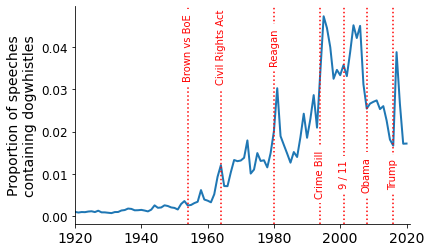

In [285]:
g = sns.lineplot(x='year',y='prop_dogwhistle_speeches',data=df_counts,linewidth=2)
add_notable_years(g)
plt.xlim((1920,2021))
plt.xlabel('',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

plt.ylabel('Proportion of speeches\ncontaining dogwhistles',fontsize=14)
sns.despine()
plt.savefig('../figures/congressional_overall_freq.pdf',bbox_inches='tight')

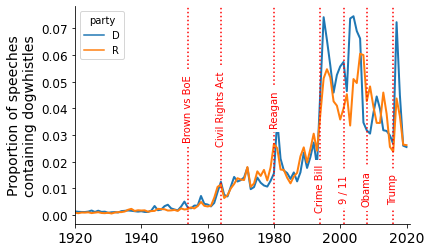

In [286]:
g = sns.lineplot(x='year',y='prop_dogwhistle_speeches',hue='party',
                 data=df_counts_by_party[df_counts_by_party['party'].isin(['D','R'])],
                linewidth=2)
add_notable_years(g)
plt.xlim((1920,2021))
plt.xlabel('',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

plt.ylabel('Proportion of speeches\ncontaining dogwhistles',fontsize=14)
sns.despine()

In [51]:
def load_nominate_scores(nominate_dir):
    df_nom_list = []
    for fname in os.listdir(nominate_dir):
        df_nom_list.append(pd.read_json(os.path.join(nominate_dir,fname),lines=True))
    #df_nom['speech_id'] = df_nom['speech_id'].astype(str)
    df_nom = pd.concat(df_nom_list).reset_index()
    return df_nom

In [52]:
df_nom = load_nominate_scores(nominate_dir)

In [77]:
df_expl = df_dogwhistle_speeches.explode('dogwhistles')
df = df_expl.merge(df_nom,on='speech_id',how='left')

In [78]:
df

,speech_id,congress,year,party,dogwhistles,index,nominate_dim1,nominate_dim2
0,560001503,56,1899,D,thugs,67863.0,-0.533,-0.136
1,560001698,56,1899,D,law and order,61770.0,-0.286,-0.067
2,560004280,56,1900,R,extremists,49441.0,0.185,0.161
3,560004548,56,1900,R,extremist,44565.0,0.485,-0.460
4,560004737,56,1900,R,law and order,10059.0,0.148,-0.495
...,...,...,...,...,...,...,...,...
315732,CREC-2020-12-30-pt1-PgS7979_0000,116,2020,D,tax cuts,68826.0,-0.428,-0.110
315733,CREC-2020-12-31-pt1-PgE1217-7_0002,116,2020,D,tax cuts,68846.0,-0.460,0.124
315734,CREC-2020-12-31-pt1-PgE1219_0002,116,2020,R,tax cuts,68847.0,0.450,0.223
315735,CREC-2020-12-31-pt1-PgS7986-2_0000,116,2020,D,tax cut,68859.0,-0.357,-0.416


In [79]:
dfs_to_plot = {}
dfs_to_plot['thug'] = df[df['dogwhistles'].isin(['thug','thugs'])]
dfs_to_plot['welfare reform'] = df[df['dogwhistles'].str.contains('welfare reform')]
dfs_to_plot['Willie Horton'] =  df[(df['dogwhistles'].str.contains('willie')) & (df['year']>=1988)]
dfs_to_plot['property rights'] = df[df['dogwhistles'].str.contains('property right')]
dfs_to_plot['hardworking Americans'] = df[(df['dogwhistles'].str.contains('hardworking'))|
                                          (df['dogwhistles'].str.contains('hard-working'))]
dfs_to_plot['personal responsibility'] = df[df['dogwhistles'].str.contains('personal responsibility')]
dfs_to_plot['politically correct'] = df[df['dogwhistles'].str.contains('correct')]

In [80]:
for dogwhistle in dfs_to_plot:
    df_dog = dfs_to_plot[dogwhistle]
    df_dog['Dogwhistle'] = dogwhistle
    dfs_to_plot[dogwhistle] = df_dog.copy()
    dfs_to_plot[dogwhistle]['Dogwhistle'] = dogwhistle

/tmp/ipykernel_2989641/395260680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dog['Dogwhistle'] = dogwhistle


In [86]:
dfs_to_plot['thug']

,speech_id,congress,year,party,dogwhistles,index,nominate_dim1,nominate_dim2,Dogwhistle
0,560001503,56,1899,D,thugs,67863.0,-0.533,-0.136,thug
27,560016755,56,1900,R,thugs,78546.0,0.406,-0.417,thug
101,560065489,56,1900,D,thugs,112306.0,-0.204,-0.066,thug
200,570020755,57,1902,D,thug,89052.0,-0.364,-0.144,thug
263,570072331,57,1902,R,thugs,95440.0,0.460,-0.888,thug
...,...,...,...,...,...,...,...,...,...
315492,CREC-2020-11-18-pt1-PgH5920_0016,116,2020,R,thugs,64728.0,0.532,0.134,thug
315531,CREC-2020-12-03-pt1-PgH6053_0001,116,2020,D,thugs,65414.0,-0.176,0.269,thug
315583,CREC-2020-12-04-pt1-PgH6850-2_0005,116,2020,R,thugs,65896.0,0.641,-0.397,thug
315694,CREC-2020-12-18-pt1-PgS7686_0019,116,2020,R,thugs,68068.0,0.821,-0.239,thug


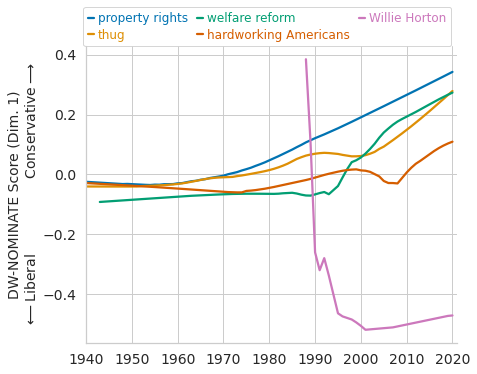

In [139]:
sns.set(style='whitegrid',palette='colorblind')
df_to_plot = pd.concat(dfs_to_plot.values())
df_sub = df_to_plot[df_to_plot['Dogwhistle'].isin(
    ['thug','welfare reform','Willie Horton','property rights','hardworking Americans'])]
sns.lmplot(x='year',y='nominate_dim1',data=df_sub,lowess=True,scatter=False,hue='Dogwhistle',palette='colorblind',
          hue_order=['property rights','thug','welfare reform','hardworking Americans','Willie Horton',],
          aspect=1.25,legend=False)
plt.ylabel('DW-NOMINATE Score (Dim. 1)\n$\longleftarrow$Liberal\t\t\tConservative$\longrightarrow$',size=14)
plt.xlabel('')
plt.xlim((1940,2021))

L=plt.legend(fontsize=12,bbox_to_anchor=(1,1.15),ncol=3,
             columnspacing=0.8,
            handletextpad=0.3,
             handlelength=.5,
             labelspacing=0.3,
            labelcolor='linecolor',
            markerscale=.5,
            )
# L.get_texts()[0].set_text('Informal Register')
# L.get_texts()[1].set_text('Formal Register')
plt.xticks(size=14)
plt.yticks(size=14)
#plt.ylabel('GPT-3 Identified Covert Meaning \n(frac. of generations)',size=14)
#plt.xlabel('Prompt Type',size=12)


plt.savefig('../figures/congressional_examples_dim1.pdf',bbox_inches='tight')